In [1]:
from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

## Сперва загрузим данные, очистим их и проведем анализ

In [2]:
data = pd.read_csv('/content/googleplaystore.csv')

In [3]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
data[data.Price == 'Everyone'].index

Int64Index([10472], dtype='int64')

In [5]:
data = data.drop([10472])

In [6]:
data.shape

(10840, 13)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          9366 non-null   float64
 3   Reviews         10840 non-null  object 
 4   Size            10840 non-null  object 
 5   Installs        10840 non-null  object 
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.2+ MB


In [8]:
data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

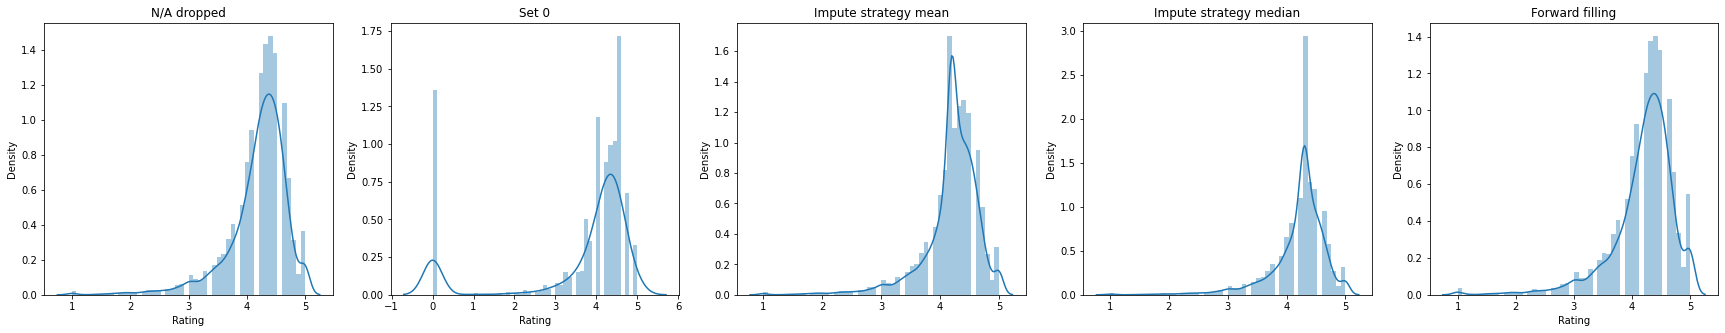

In [10]:
#Осуществлено методом установки 0, среднего значения, медианного значения и методом установки блиайшего указанного значения.
mean_imp = SimpleImputer(strategy="mean")
med_imp = SimpleImputer(strategy="median")

fig, ax =plt.subplots(1,5, figsize=(30,5))
ax[0].set_title('N/A dropped')
ax[1].set_title('Set 0')
ax[2].set_title('Impute strategy mean')
ax[3].set_title('Impute strategy median')
ax[4].set_title('Forward filling')
sns.distplot(data["Rating"].dropna(), ax=ax[0])
sns.distplot(data["Rating"].fillna(0), ax=ax[1])
sns.distplot(mean_imp.fit_transform(data[["Rating"]]), ax=ax[2])
sns.distplot(med_imp.fit_transform(data[["Rating"]]), ax=ax[3])
sns.distplot(data["Rating"].fillna(method='ffill'), ax=ax[4])
fig.show()

Установка пропущенных значений в 0 дает выброс. Выберу стратегию Foward Filling. Выбор связан с тем, что не хочу выкидывать объекты из выборки.

In [6]:
#data.dropna(inplace = True)
#data["Rating"].dropna(inplace = True)
data["Rating"].fillna(method='ffill', inplace = True)

In [12]:
data.shape

(10840, 13)

In [13]:
data.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       2
dtype: int64

In [7]:
# Преобразую Type в бинарные значения
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

data['Type'] = data['Type'].map(type_cat)
data["Type"].fillna(method='ffill', inplace = True)

In [15]:
data["Type"].value_counts()

0    10039
1      801
Name: Type, dtype: int64

In [16]:
data.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       2
dtype: int64

In [8]:
# Очистка content rating классификации
RatingL = data['Content Rating'].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
data['Content Rating'] = data['Content Rating'].map(RatingDict).astype(int)

In [18]:
data.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       2
dtype: int64

In [9]:
# Эти признаки выкину, тк они не пригодятся для обучения модели
data.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

In [10]:
# Очистка признака size 
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

data["Size"] = data["Size"].map(change_size)

#filling Size which had NA
data.Size.fillna(method = 'ffill', inplace = True)

Text(0, 0.5, 'Frequency')

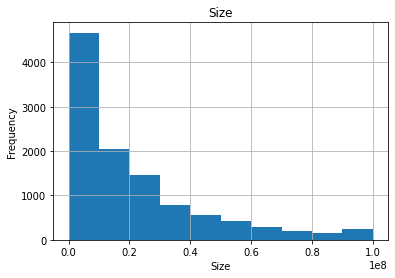

In [21]:
data.hist(column='Size')
plt.xlabel('Size')
plt.ylabel('Frequency')

In [11]:
# Очистка признака Installs
data['Installs']=data['Installs'].apply(lambda x: x.strip('+'))
data['Installs']=data['Installs'].apply(lambda x: x.replace(',',''))
data['Installs']=data['Installs'].replace('Free',np.nan)
data['Installs']=pd.to_numeric(data['Installs'], downcast='float')

In [12]:
#filling Size which had NA
data['Installs'].fillna(method = 'ffill', inplace = True)

In [13]:
data.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
dtype: int64

In [13]:
# Очистка признака Price
data['Price'] = data['Price'].apply(lambda x: x.replace('$',''))
data['Price']=pd.to_numeric(data['Price'])

In [14]:
# преобразую reviews к numeric
data['Reviews'] = data['Reviews'].astype(float)

In [15]:
# Закодирую категориальные признаки в числовые
le = LabelEncoder()
category = le.fit_transform(data['Category'].dropna())
genres = le.fit_transform(data['Genres'].dropna())
data['Category_num'] = category
data['Genres_num'] = genres

In [16]:
data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_num,Genres_num
0,ART_AND_DESIGN,4.1,159.0,19000000.0,10000.0,0,0.0,0,Art & Design,0,9
1,ART_AND_DESIGN,3.9,967.0,14000000.0,500000.0,0,0.0,0,Art & Design;Pretend Play,0,12
2,ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000.0,0,0.0,0,Art & Design,0,9
3,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000.0,0,0.0,1,Art & Design,0,9
4,ART_AND_DESIGN,4.3,967.0,2800000.0,100000.0,0,0.0,0,Art & Design;Creativity,0,11


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        10840 non-null  object 
 1   Rating          10840 non-null  float64
 2   Reviews         10840 non-null  float64
 3   Size            10840 non-null  float64
 4   Installs        10840 non-null  float32
 5   Type            10840 non-null  int64  
 6   Price           10840 non-null  float64
 7   Content Rating  10840 non-null  int64  
 8   Genres          10840 non-null  object 
 9   Category_num    10840 non-null  int64  
 10  Genres_num      10840 non-null  int64  
dtypes: float32(1), float64(4), int64(4), object(2)
memory usage: 973.9+ KB


Очищено!

In [17]:
# Основные статистики датасета
data.describe()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Category_num,Genres_num
count,10840.000000,1.084000e+04,1.084000e+04,1.084000e+04,10840.000000,10840.000000,10840.000000,10840.000000,10840.000000
mean,4.191577,4.441529e+05,2.184622e+07,1.546429e+07,0.073893,1.027368,0.327952,16.725369,64.264114
std,0.546512,2.927761e+06,2.252324e+07,8.502664e+07,0.261609,15.949703,0.761608,8.353310,32.646723
min,1.000000,0.000000e+00,8.500000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.800000e+01,5.100000e+06,1.000000e+03,0.000000,0.000000,0.000000,11.000000,38.000000
50%,4.300000,2.094000e+03,1.400000e+07,1.000000e+05,0.000000,0.000000,0.000000,14.000000,67.000000
75%,4.500000,5.477550e+04,3.000000e+07,5.000000e+06,0.000000,0.000000,0.000000,25.000000,96.000000
max,5.000000,7.815831e+07,1.000000e+08,1.000000e+09,1.000000,400.000000,5.000000,32.000000,118.000000


## Визуальное исследование датасета

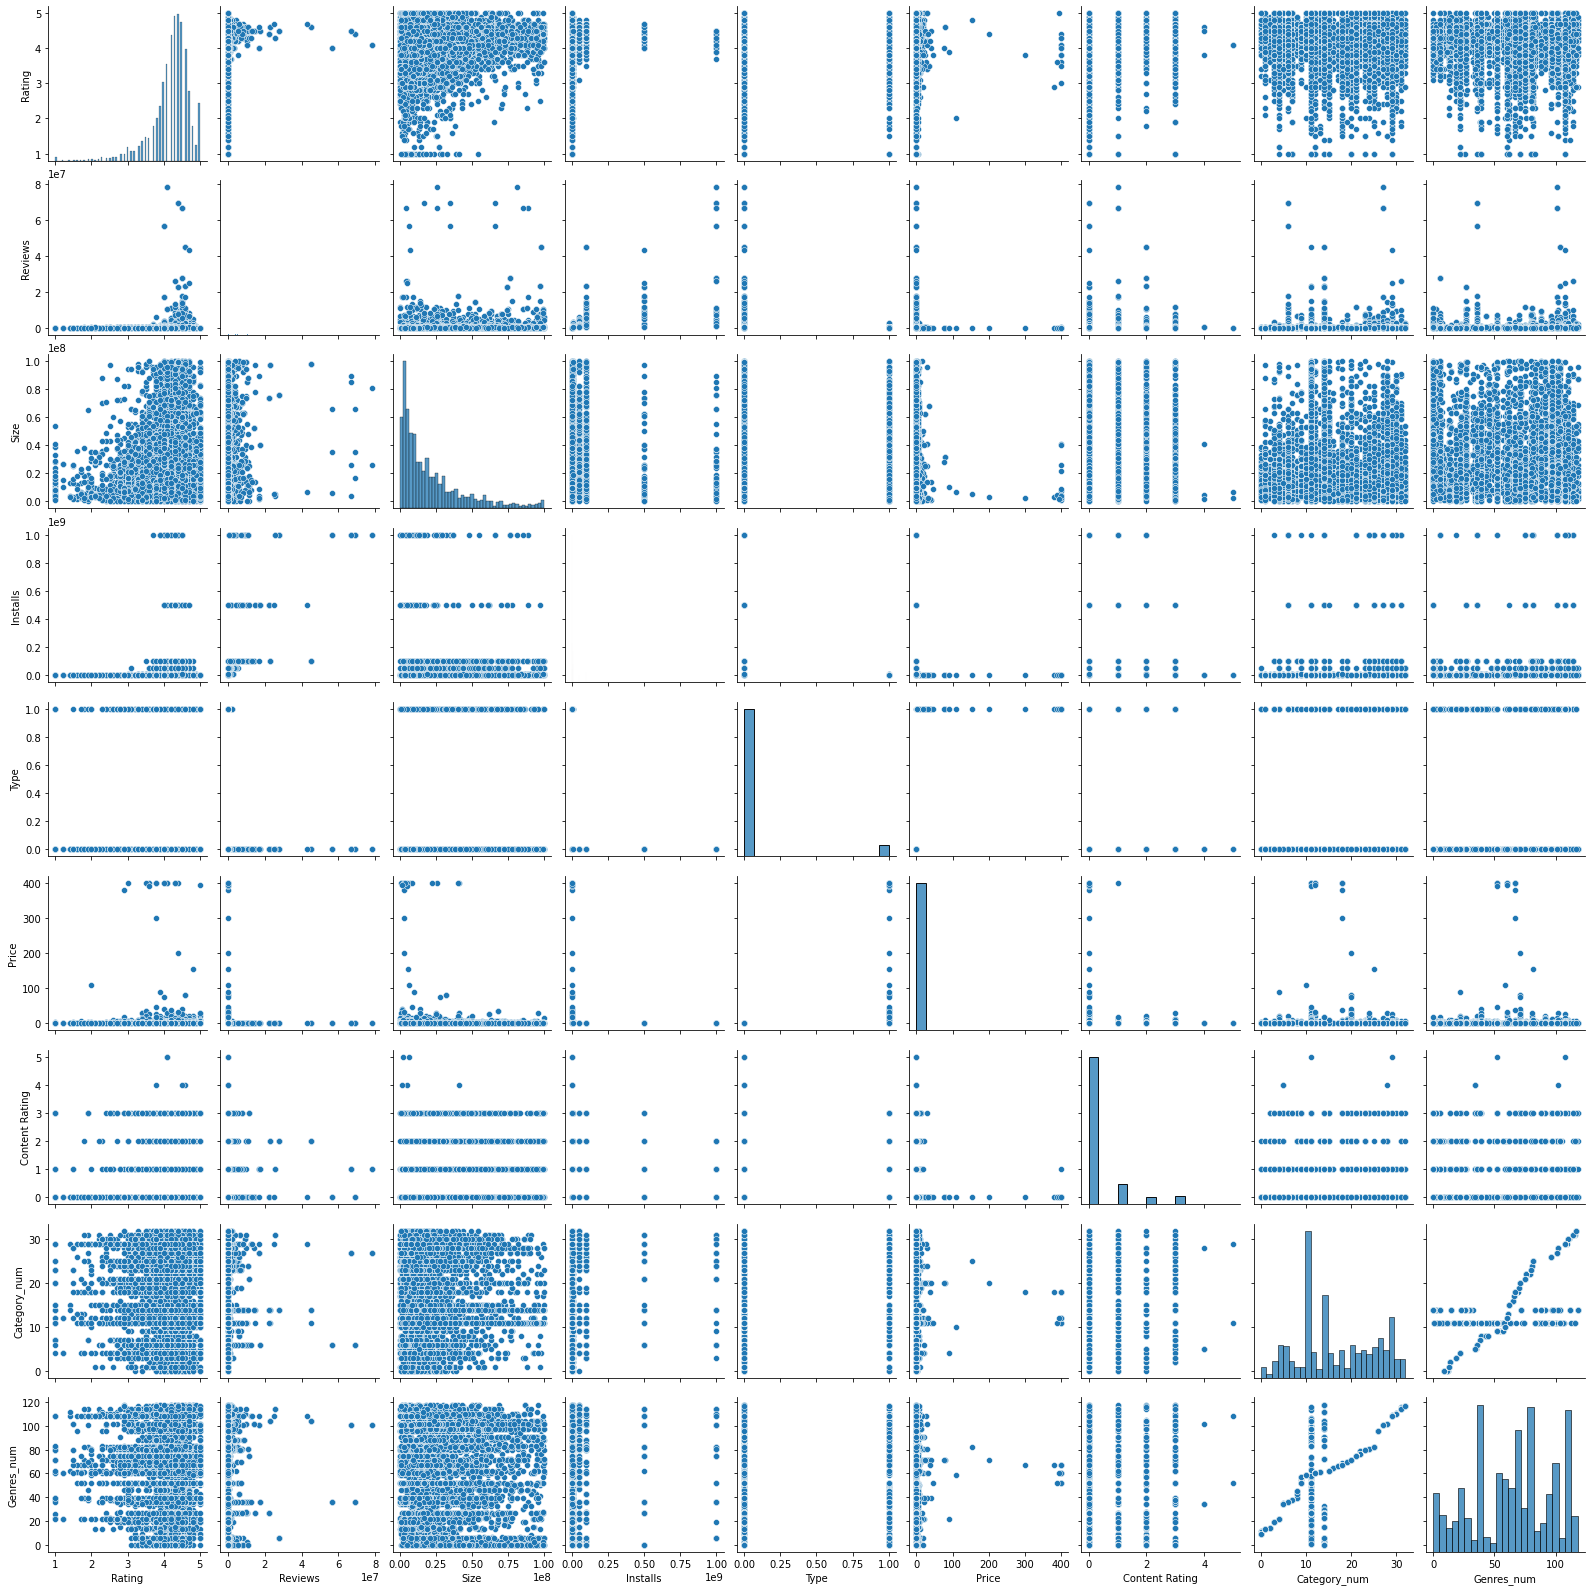

In [33]:
sns.pairplot(data)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


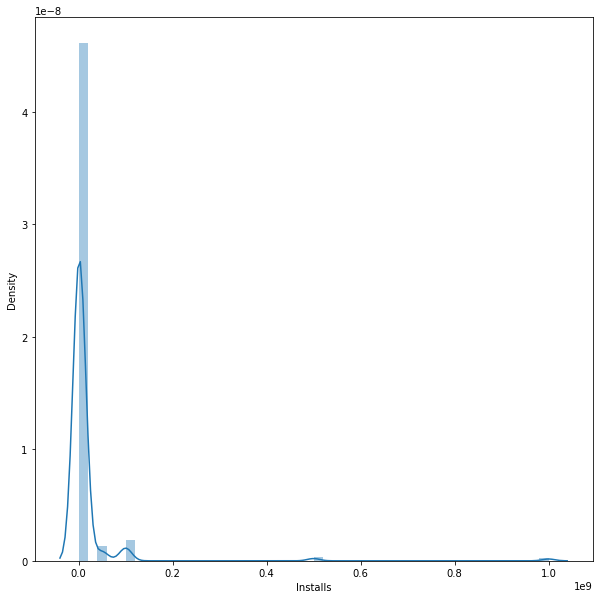

In [34]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(data['Installs'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


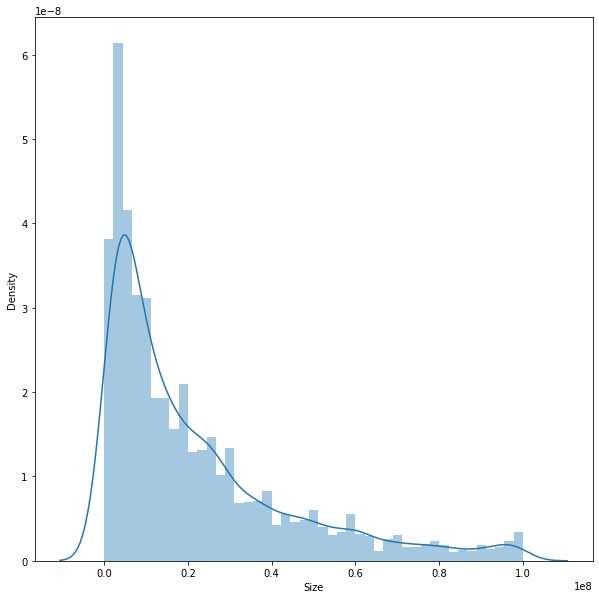

In [35]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(data['Size'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


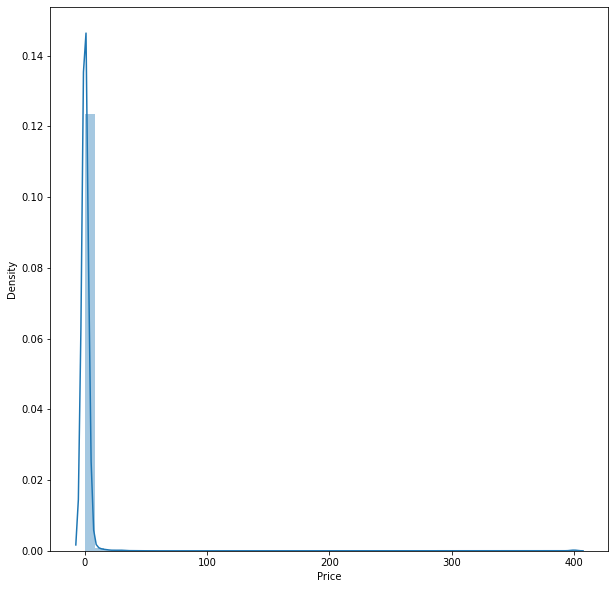

In [36]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(data['Price'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

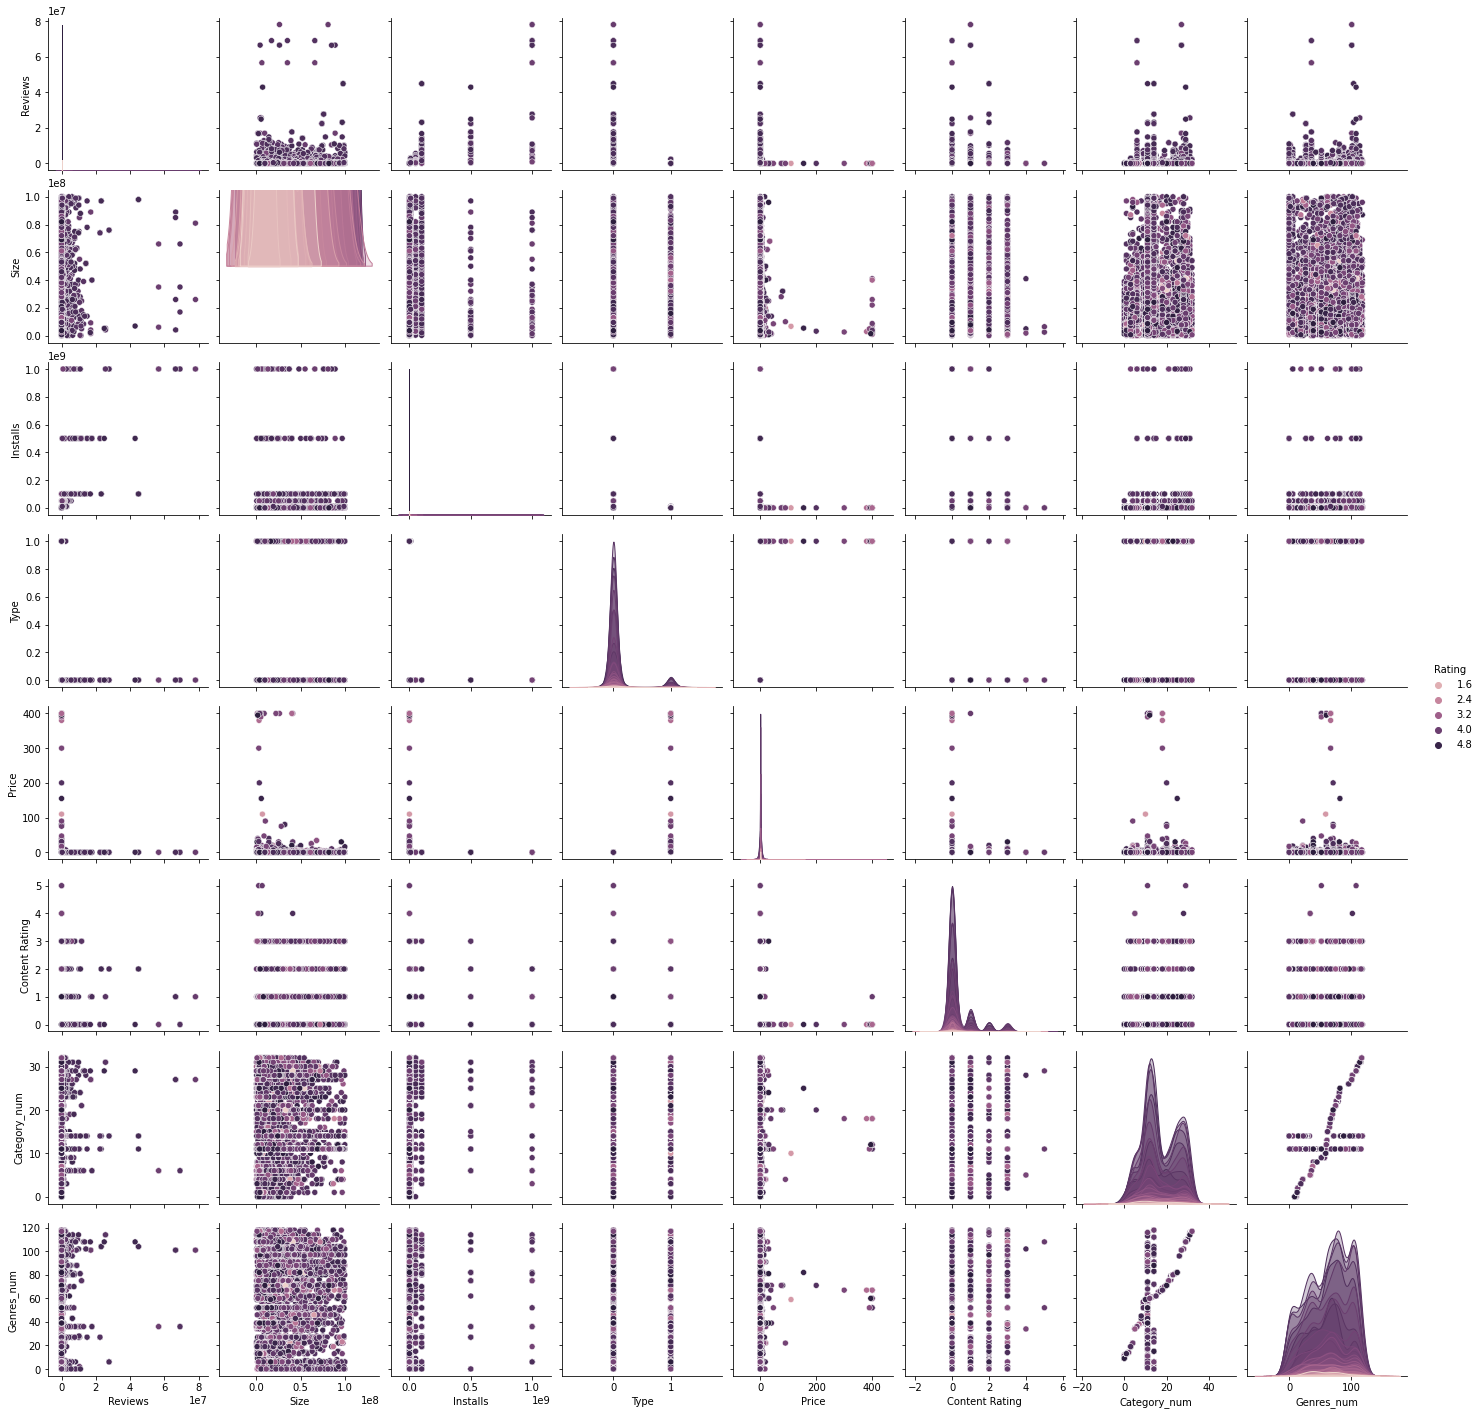

In [37]:
sns.pairplot(data, hue="Rating")

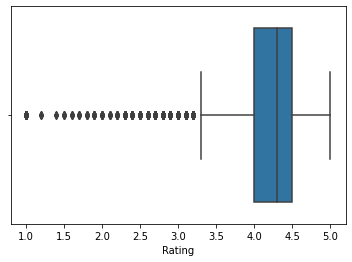

In [ ]:
sns.boxplot(x=data['Rating'])

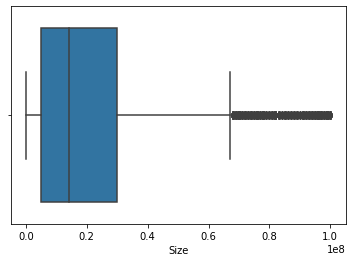

In [ ]:
sns.boxplot(x=data['Size'])

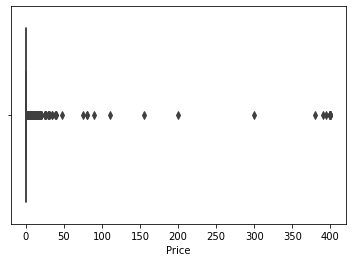

In [ ]:
sns.boxplot(x=data['Price'])

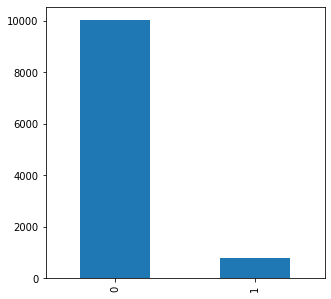

In [ ]:
# Free apps are more
data['Type'].value_counts().plot(kind = 'bar', figsize = (5,5))

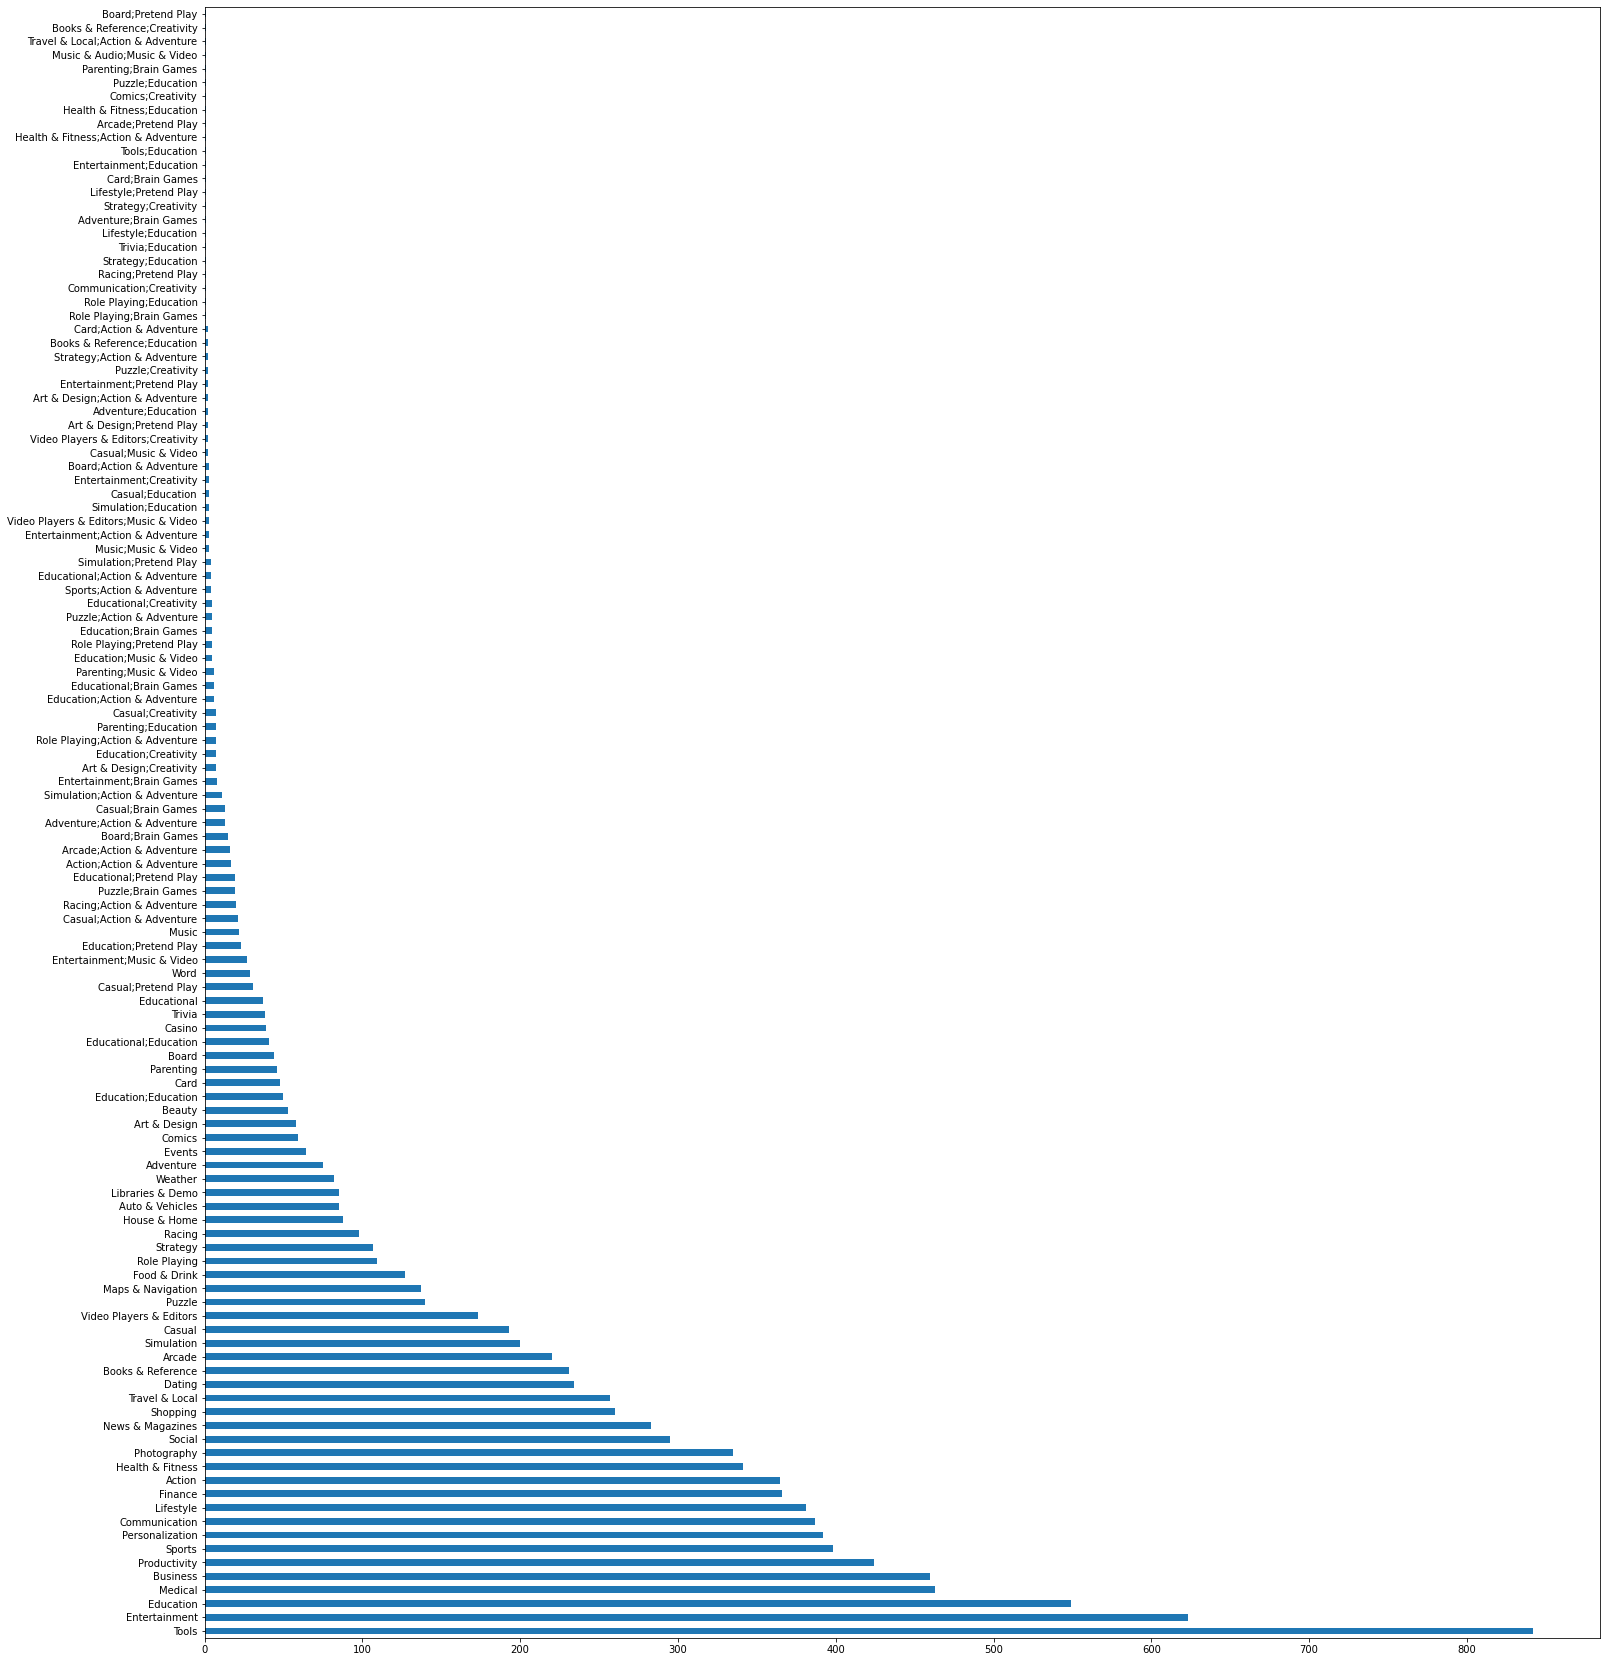

In [ ]:
data['Genres'].value_counts().plot(kind='barh',figsize=(25,30))

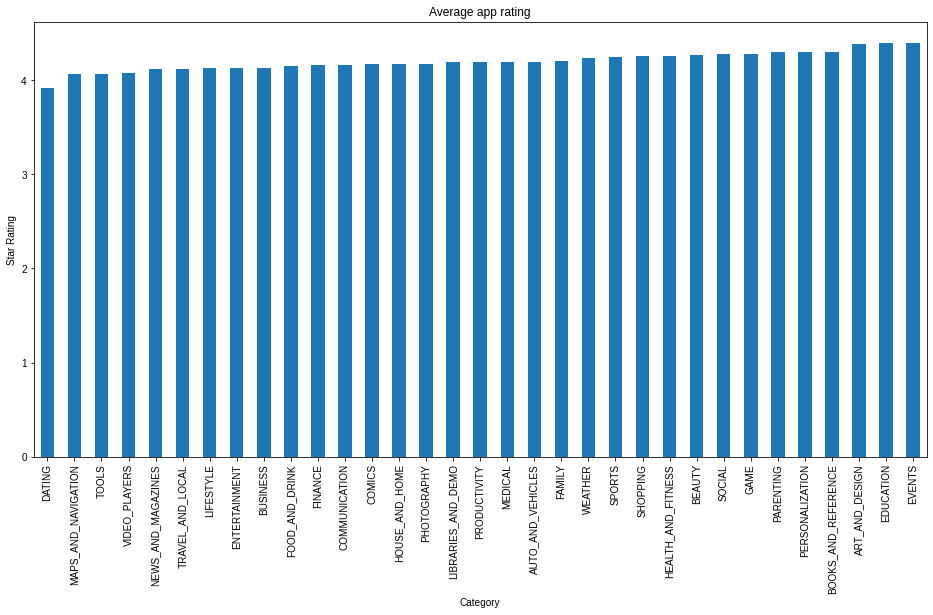

In [ ]:
# Отображу на гисторгамме средний рейтинг приложений в каждой категории
fig = plt.figure(figsize=(16,8)) 
data.groupby('Category').mean().sort_values(by='Rating',ascending='False')['Rating'].plot(kind='bar',title='Average app rating', fontsize=10)
plt.ylabel('Star Rating') 
plt.style.use('seaborn-white')

Text(0, 0.5, 'Average price - USD')

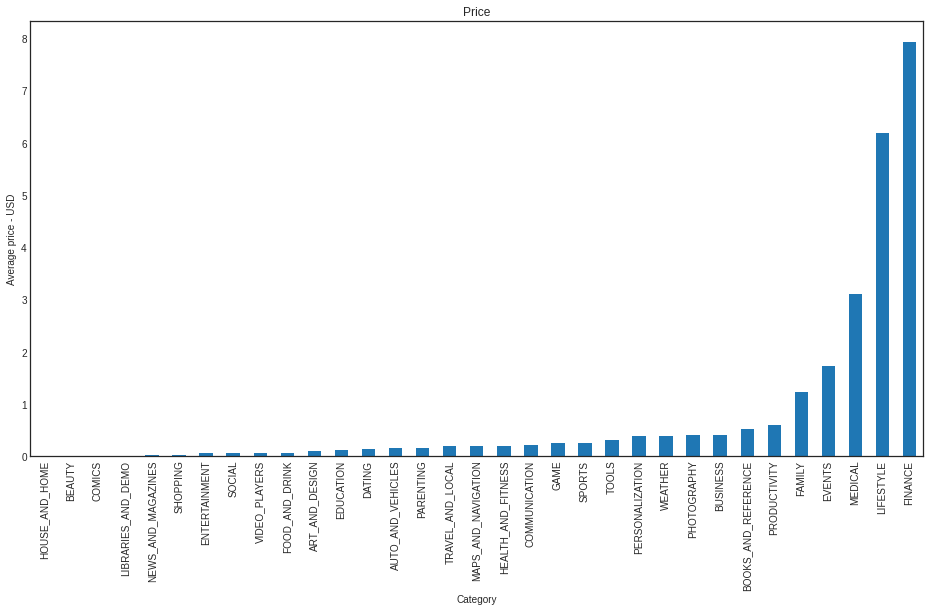

In [ ]:
# Отображу на гисторгамме среднюю стоимость приложений в каждой категории
fig = plt.figure(figsize=(16,8)) 
data.groupby('Category').mean().sort_values(by='Price',ascending='False')['Price'].plot(kind='bar',title='Price', fontsize=10)
plt.ylabel('Average price - USD') 

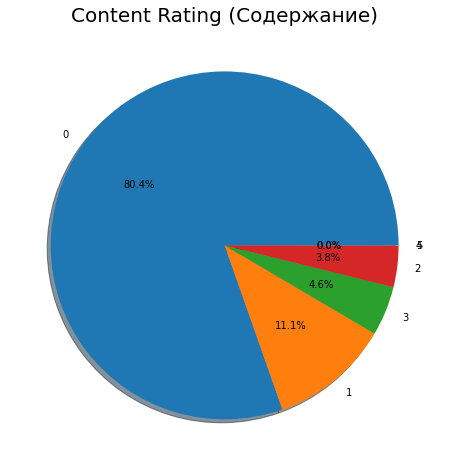

In [39]:
fig = plt.figure(figsize=(16,8)) 
labels = data['Content Rating'].value_counts(sort = True).index
sizes = data['Content Rating'].value_counts(sort = True)
plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True)
plt.title('Content Rating (Содержание)',size = 20)
plt.show()
# 0 - Everyone
# 1 - Teen
# 2 - Everyone 10+
# 3 - Mature 17+
# 4 - Adult 18+(0.0%)

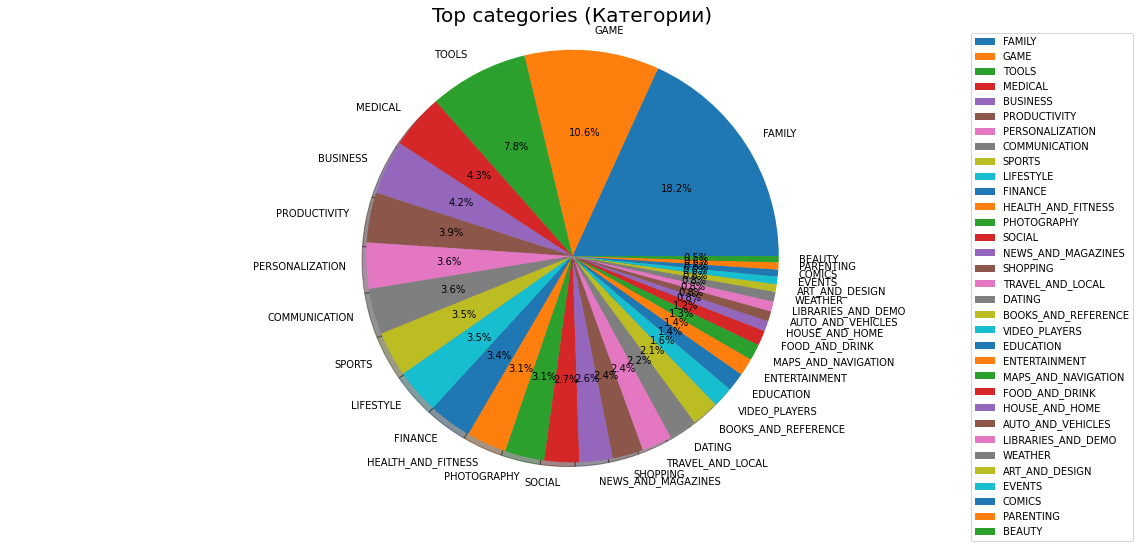

In [40]:
fig = plt.figure(figsize=(16,8)) 
labels = data['Category'].value_counts(sort = True).index
sizes = data['Category'].value_counts(sort = True)
plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True)
plt.title('Top categories (Категории)',size = 20)
plt.legend(labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

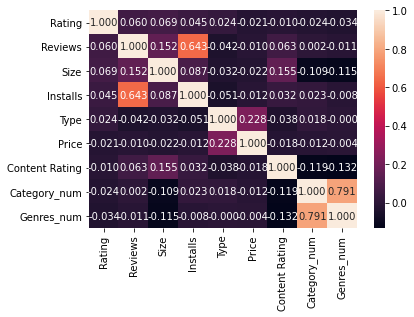

In [41]:
sns.heatmap(data.corr(), annot=True, fmt='.3f')

С целевым признаком (Rating) остальные признаки коррелируют незначительно.
При построении регрессионных моделей МО не буду брать во внимание признаки Genres_num, Category_num, так как на целевой признак они влияния не оказывают, а между собой коррелируют достаточно сильно, поэтому будут ухудшать качество моделей.

## Разделение данных для начала обучения моделей

In [18]:
X = data.drop(["Rating", "Genres_num", "Category_num", "Category", "Genres"], axis=1)
y = data["Rating"]

In [44]:
print(X.shape)
print(y.shape)

(10840, 6)
(10840,)


Предобрабатываю данные, чтобы методы работали лучше

In [19]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Reviews,Size,Installs,Type,Price,Content Rating
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,-2.138109e-15,1.651623e-16,-7.755993e-16,-1.986603e-15,-3.332093e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-9.696086e-01,-1.818790e-01,-2.824692e-01,-6.441596e-02,-4.306245e-01
25%,-1.516980e-01,-7.435428e-01,-1.818672e-01,-2.824692e-01,-6.441596e-02,-4.306245e-01
50%,-1.509957e-01,-3.483772e-01,-1.807028e-01,-2.824692e-01,-6.441596e-02,-4.306245e-01
75%,-1.330011e-01,3.620329e-01,-1.230730e-01,-2.824692e-01,-6.441596e-02,-4.306245e-01
max,2.654511e+01,3.470077e+00,1.157931e+01,3.540210e+00,2.501558e+01,6.134733e+00


Разделю выборку на обучающую и тестовую

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.2, random_state=88888888)

In [47]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8672, 6)
(2168, 6)
(8672,)
(2168,)


Введу метрики качества, которые буду использовать для оценки работы регрессионных моделей.

Это Средняя абсолютная ошибка, медианная абсолютная ошибка и коэффициент детерминации.

In [21]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

## Линейная регрессионная модель

In [22]:
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
print(lin.coef_)
print(lin.intercept_)

[ 0.02582903  0.0354589   0.00591791  0.01891035 -0.01259621 -0.01199352]
4.189020717509646


In [24]:
test_model(lin)

mean_absolute_error: 0.3733082327784229
median_absolute_error: 0.2653829352271073
r2_score: 0.008369972349998256


In [25]:
las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
test_model(las_1)

mean_absolute_error: 0.3761631679681649
median_absolute_error: 0.3107357011070109
r2_score: -0.0004681017686054556


Линейная регрессия справилась лучше. Так как r2_score у Лассо отрицательный(значит модель Лассо еще хуже горизонтальной линии подгонки).

Можно подобрать параметр альфа для Лассо при помощи решетчетого поиска.

In [27]:
param_range = np.arange(0.001, 3.001, 0.1)
tuned_parameters = [{'alpha': param_range}]
tuned_parameters

[{'alpha': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
         6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
         1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
         1.801e+00, 1.901e+00, 2.001e+00, 2.101e+00, 2.201e+00, 2.301e+00,
         2.401e+00, 2.501e+00, 2.601e+00, 2.701e+00, 2.801e+00, 2.901e+00])}]

In [28]:
gs = GridSearchCV(Lasso(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

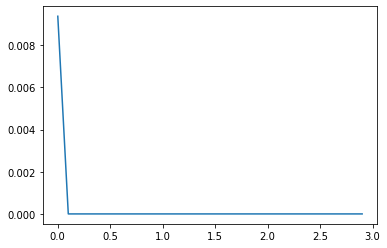

In [29]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

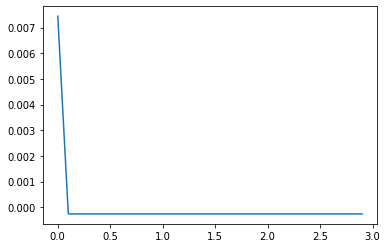

In [30]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [31]:
las_gs = Lasso(**gs.best_params_)
las_gs.fit(X_train, y_train)
test_model(las_gs)

mean_absolute_error: 0.37332751832438693
median_absolute_error: 0.26475595932349405
r2_score: 0.00831533566635756


Результат работы модели лучше., как у обычной линейной регрессии(в данном случае множественная линейная регрессия).

## SVM

In [32]:
svr_model = SVR(kernel='rbf', gamma=0.8, C=1.0)
svr_model.fit(X_train, y_train)
test_model(svr_model)

mean_absolute_error: 0.3546953644410346
median_absolute_error: 0.22727545269209415
r2_score: 0.0078628208220346


Метрики качества у модели SVR показывают лучшие результаты, нежели у модели Lasso и LinearRegression.

## Дерево принятия решений

Попробуем дерево решений с неограниченной глубиной дерева:

In [33]:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)
test_model(dt_none)

mean_absolute_error: 0.4592926331049025
median_absolute_error: 0.2999999999999998
r2_score: -0.7710998141770435


In [34]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

In [35]:
stat_tree(dt_none)

Всего узлов: 13281
Листовых узлов: 6641
Глубина дерева: 37
Минимальная глубина листьев дерева: 5
Средняя глубина листьев дерева: 18.615268784821563


In [36]:
param_range = np.arange(1, 40, 2)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39])}]

In [37]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

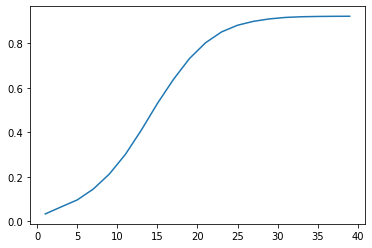

In [38]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

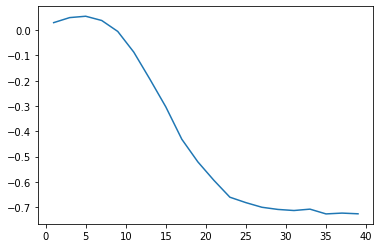

In [39]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем дополнительное исследование в районе пика (5).

In [40]:
param_range = np.arange(1, 8, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([1, 2, 3, 4, 5, 6, 7])}]

In [41]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

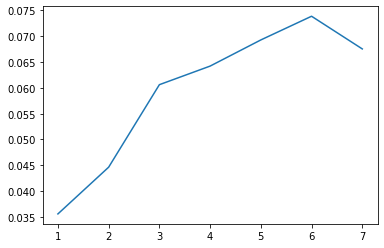

In [42]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Пик приходится на значение 6.

In [43]:
dt_gs = gs.best_estimator_
dt_gs.fit(X_train, y_train)
test_model(dt_gs)

mean_absolute_error: 0.3531026893215798
median_absolute_error: 0.24589041095890218
r2_score: 0.08225460405712526


In [44]:
stat_tree(dt_gs)

Всего узлов: 121
Листовых узлов: 61
Глубина дерева: 6
Минимальная глубина листьев дерева: 5
Средняя глубина листьев дерева: 5.950819672131147


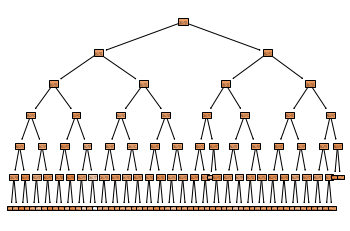

In [45]:
plot_tree(dt_gs, filled=True);

## Случайный лес

In [46]:
ran_88 = RandomForestRegressor(n_estimators=88)
ran_88.fit(X_train, y_train)
test_model(ran_88)

mean_absolute_error: 0.3620438257349914
median_absolute_error: 0.2329545454545492
r2_score: -0.0441767637183299


Подберем параметры при помощи решетчатого поиска.

In [47]:
param_range = np.arange(1, 252, 10)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
         131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251])}]

In [48]:
gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=211, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

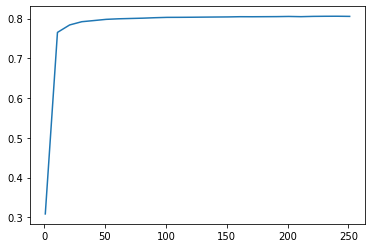

In [49]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

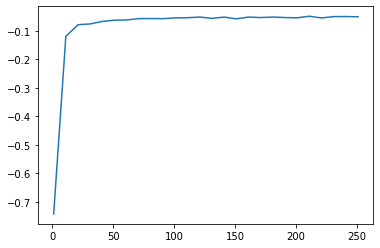

In [50]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [51]:
ran_gs = gs.best_estimator_
ran_gs.fit(X_train, y_train)
test_model(ran_gs)

mean_absolute_error: 0.3617736338121027
median_absolute_error: 0.22748815165876568
r2_score: -0.04296384862894187


Метрики качества хуже, чем у модели SVR.

In [52]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(15,7)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

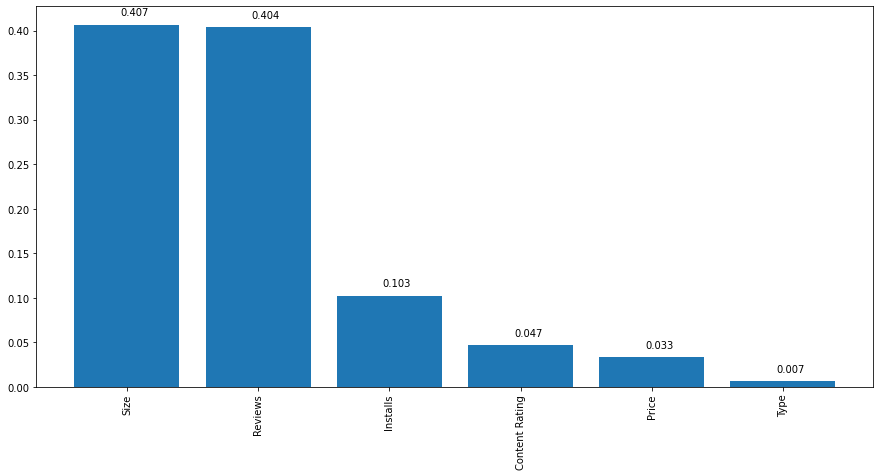

In [53]:
# Важность признаков
x_ds = pd.DataFrame(data=X_train, columns=['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating'])
_,_ = draw_feature_importances(ran_gs, x_ds)

## Ансамблевая модель - градиентный бустинг

In [54]:
gr_88 = GradientBoostingRegressor(n_estimators=88)
gr_88.fit(X_train, y_train)
test_model(gr_88)

mean_absolute_error: 0.34949487524440265
median_absolute_error: 0.24040366663194312
r2_score: 0.09440792909325046


In [55]:
tuned_parameters

[{'n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
         131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251])}]

In [56]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=121,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

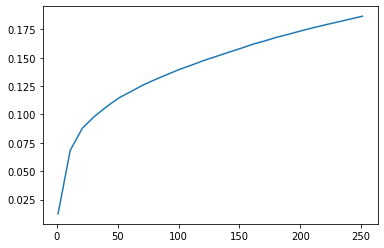

In [57]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

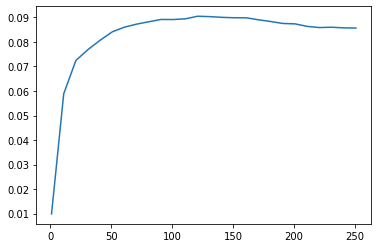

In [58]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [59]:
gb_gs = gs.best_estimator_
gb_gs.fit(X_train, y_train)
test_model(gb_gs)

mean_absolute_error: 0.34842670429725164
median_absolute_error: 0.24193123437548492
r2_score: 0.09569158951859791


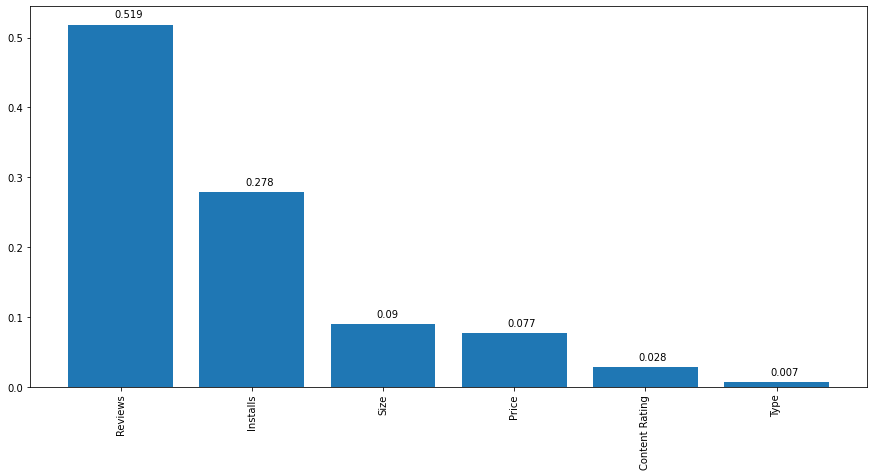

In [60]:
# Важность признаков
x_ds = pd.DataFrame(data=X_train, columns=['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating'])
_,_ = draw_feature_importances(gb_gs, x_ds)

Метрики качества хуже, чем у SVR.

In [61]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

In [62]:
# Модели без подбора параметров
regr_models = {'SVR':svr_model,
               'LinearRegression': lin,
               'Lasso': las_1,
               'DT': dt_none,
               'RF': ran_88,
               'GB': gr_88,
              }

In [63]:
regrMetricLogger = MetricLogger()

In [64]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MedAE', model_name, medae)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MedAE={}, R2={}'.format(
        round(mae, 3), round(medae, 3), round(r2, 3)))
    print('*****************************************************')

In [65]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.8,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE=0.355, MedAE=0.227, R2=0.008
*****************************************************
*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.373, MedAE=0.265, R2=0.008
*****************************************************
*****************************************************
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

MAE=0.376, MedAE=0.311, R2=-0.0
*****************************************************
*****************************************************
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_fea

Модель SVR вроде как показывает достаточно хорошие результаты, но надо визуально увидить это.

In [66]:
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MedAE', 'R2'], dtype=object)

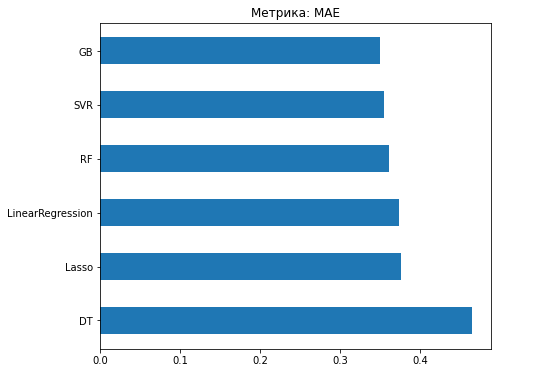

In [67]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', 
                      ascending=False, figsize=(7, 6))

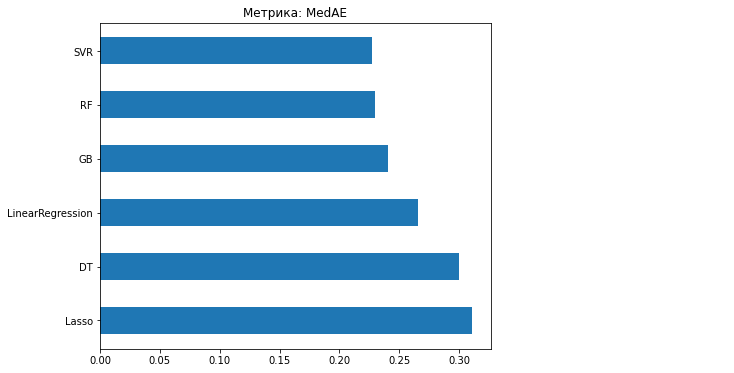

In [68]:
regrMetricLogger.plot('Метрика: ' + 'MedAE', 'MedAE', 
                      ascending=False, figsize=(7, 6))

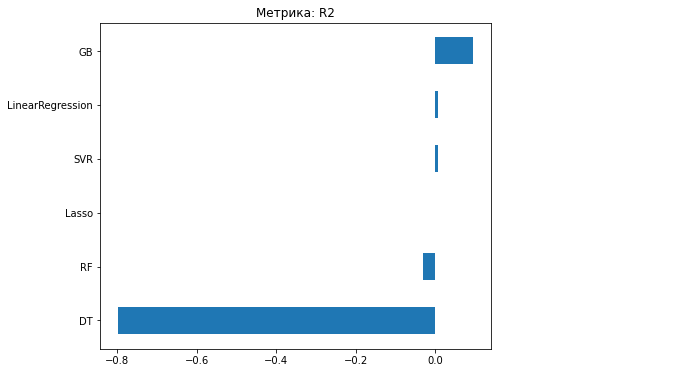

In [69]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2',
                      ascending=True, figsize=(7, 6))

SVR показывает хорошие результаты, но этом наборе данных она справляется в достаточной мере. 

In [77]:
# Модели с подбором параметров
regr_models = {'SVR':svr_model,
              'Lasso':las_gs,
               'DT': dt_gs,
               'RF': ran_gs,
               'GB': gb_gs,
              }

In [78]:
regrMetricLogger = MetricLogger()

In [79]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.8,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE=0.355, MedAE=0.227, R2=0.008
*****************************************************
*****************************************************
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

MAE=0.373, MedAE=0.265, R2=0.008
*****************************************************
*****************************************************
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, 

In [80]:
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MedAE', 'R2'], dtype=object)

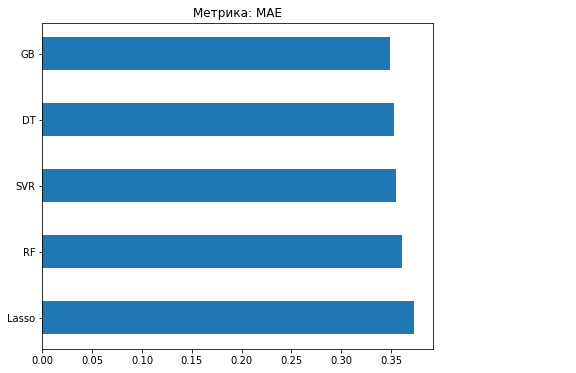

In [81]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', 
                      ascending=False, figsize=(7, 6))

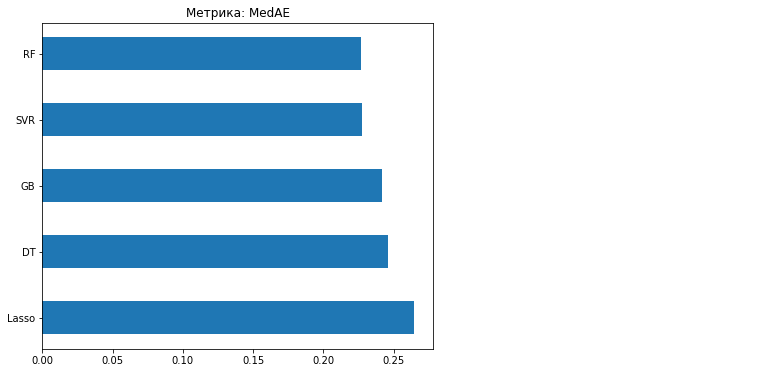

In [82]:
regrMetricLogger.plot('Метрика: ' + 'MedAE', 'MedAE', 
                      ascending=False, figsize=(7, 6))

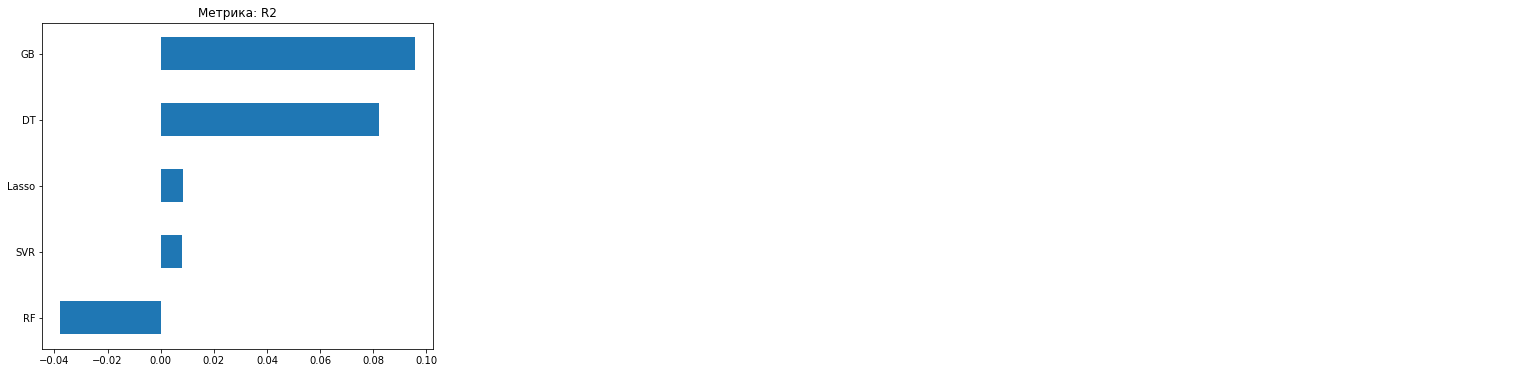

In [83]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2',
                      ascending=True, figsize=(7, 6))

Хотя для модели SVR я не подбирала параметры при помощи решетчатого поиска(код работал очень долго и изначально данная модель показала лучшие результаты на наборе д-х), выберу эту модель и в этом случае. В сравнении с моделями, где я подбирала параметры SVR достаточно не плохо справляется. 